In [1]:
import os, sys, re, gc

WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from MUI_model.utils.dataset import JDNDataset
from MUI_model.utils.model import JDIModel
from MUI_model.utils.labels import assign_labels
from MUI_model.utils.common import accuracy
from MUI_model.utils.config import logger
# from utils.dataset_builder import DatasetBuilder

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import seaborn as sns
from time import sleep

2021-08-27 15:50:56,937 -INFO - config.py:25 - Module utils.config was loaded
2021-08-27 15:50:56,985 -INFO - common.py:112 - Module utils.common is loaded...
2021-08-27 15:50:56,988 -INFO - hidden.py:63 - hidden module is loaded
2021-08-27 15:50:57,521 -INFO - features_builder.py:557 - feature_bilder module is loaded...
2021-08-27 15:50:57,890 -INFO - dataset.py:123 - dataset module is loaded...


In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
def get_grey_image(file_path: str) -> np.ndarray:
    img = plt.imread(file_path)
    img = (img[..., 0] + img[..., 1] + img[..., 2]) / 3.0
    return img

In [4]:
SITE_URL = 'file:///C:/WORK/jdi-qasp-ml/MUI_model/dataset/site121/index.html'
DATASET_NAME = 'mui-site121'
WAIT_TIME_SECONDS = 7
# URL = 'https://jdi-testing.github.io/jdi-light/'
# SITE_URL = 'https://jdi-testing.github.io/jdi-light/material/buttons'
# PREDICT_URL = 'http://localhost:5000/predict'

# LOGIN = 'Roman'
# PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True

In [5]:
class DatasetBuilder:
    """
        Build dataset from a specific url,

    """

    headless = True

    def __init__(self, url: str, dataset_name: str = 'dummy', headless=True):

        if dataset_name == 'dummy':
            logger.warning('The default dataset name "dummy" will be used')
        else:
            logger.info(f'Dataset name: {dataset_name}')

        super(DatasetBuilder).__init__()
        self.url = url
        self.driver = None
        self.logger = logger
        self.dataset_name = dataset_name
        self.headless = headless

        logger.info('Create directories to save the dataset')
        # logger.info('dataset/images')
        os.makedirs('MUI_model/dataset/images', exist_ok=True)
        # logger.info('dataset/df')
        os.makedirs('MUI_model/dataset/df', exist_ok=True)
        # logger.info('dataset/annotations')
        os.makedirs('MUI_model/dataset/annotations', exist_ok=True)
        # logger.info('dataset/html')
        os.makedirs('MUI_model/dataset/html', exist_ok=True)
        # logger.info('dataset/cache-labels')
        os.makedirs('MUI_model/dataset/cache-labels', exist_ok=True)

        self.__enter__()

    def __exit__(self, exc_type, exc_val, exc_tb):
        logger.info('Close web driver')
        self.driver.close()

    def __enter__(self):
        import selenium
        from selenium.webdriver.chrome.options import Options

        if self.driver is not None:
            return self

        self.options = Options()
        # Last I checked this was necessary.
        self.options.add_argument('--disable-gpu')
        self.options.add_argument('--skip-js-errors')

        # to prevent "I'm not a robot" check, we have to add next option:
        self.options.add_argument('--user-agent="Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36")') # noqa
        if sys.platform != 'darwin':
            self.options.set_capability("platformName", "windows")
        # self.options.add_argument("--start-maximized")
        if self.headless:
            self.options.add_argument('--headless')

        logger.info('Creating driver')
        if sys.platform == 'darwin':
            chrome_driver_path = '/usr/local/bin/chromedriver'
        else:
            chrome_driver_path = os.path.join(os.getcwd(), 'chromedriver.exe')
        if os.path.exists(chrome_driver_path):
            self.driver = selenium.webdriver.Chrome(
                executable_path=chrome_driver_path, options=self.options)
        else:
            raise FileNotFoundError(f"chromedriver.exe  {os.getcwd()}")

        logger.info('Chrome web driver is created')
        self.setUp(self.driver)
        scr = f'MUI_model/dataset/images/{self.dataset_name}.png'
        logger.info(f'save scrinshot: {scr}')
        self.driver.save_screenshot(scr)
        self.build_dataset()

        return self

    def full_page(self, driver):
        logger.info('Getting full page')
        sleep(3.0)
        html_e = driver.find_element_by_tag_name('html')
        sleep(3.0)
        html_e.send_keys(Keys.CONTROL, Keys.END)
        sleep(3.0)
        html_e.send_keys(Keys.CONTROL, Keys.END)
        sleep(3.0)

        maximize_window(driver=self.driver, extend_pix=0)

        sleep(9.0)
        html_e.send_keys(Keys.CONTROL, Keys.END)
        sleep(3.0)

    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns
        """
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)

        # As an example:
        # driver.find_element_by_id("user-icon").click()
        # driver.find_element_by_id("name").send_keys(LOGIN)
        # driver.find_element_by_id("password").send_keys(PASSWORD)
        # driver.find_element_by_id("login-button").click()
        # sleep(3.0)
        maximize_window(driver=self.driver, extend_pix=0)

        # self.full_page(driver)

    def build_dataset(self):

        logger.info('Collect features using JS script')
        with open('js/build-dataset.js', 'r') as f:
            build_dataset_js = f.read()

        self.dataset_json = self.driver.execute_script(build_dataset_js)
        self.dataset = pd.DataFrame(self.dataset_json)

        # Save HTML source
        logger.info(f'Save html to MUI_model/dataset/html/{self.dataset_name}.html')
        with open(f'MUI_model/dataset/html/{self.dataset_name}.html', 'wb') as f:
            f.write(self.driver.page_source.encode())
            f.flush()

        self.dataset.onmouseover = self.dataset.onmouseover.apply(
            lambda x: 'true' if x is not None else None)
        self.dataset.onmouseenter = self.dataset.onmouseenter.apply(
            lambda x: 'true' if x is not None else None)

        logger.info(f'Save parquet to MUI_model/dataset/df/{self.dataset_name}.parquet')

        logger.info("No attributes: " + str(self.dataset[self.dataset.attributes == {}].shape))

        self.dataset.attributes = self.dataset.attributes.apply(lambda x: None if x == {} else x)

        self.dataset.to_parquet(f'MUI_model/dataset/df/{self.dataset_name}.parquet')

        return self.dataset


logger.info("dataset package is loaded...")

2021-08-27 15:50:58,118 -INFO - 4109918096.py:148 - dataset package is loaded...


2021-08-27 15:50:58,133 -INFO - 4109918096.py:14 - Dataset name: mui-site121
2021-08-27 15:50:58,135 -INFO - 4109918096.py:23 - Create directories to save the dataset
2021-08-27 15:50:58,280 -INFO - 4109918096.py:61 - Creating driver
2021-08-27 15:50:59,469 -INFO - 4109918096.py:72 - Chrome web driver is created
2021-08-27 15:50:59,470 -INFO - 598994738.py:4 - getting page
2021-08-27 15:51:07,032 -INFO - 4109918096.py:75 - save scrinshot: MUI_model/dataset/images/mui-site121.png
2021-08-27 15:51:07,406 -INFO - 4109918096.py:119 - Collect features using JS script
2021-08-27 15:51:08,646 -INFO - 4109918096.py:127 - Save html to MUI_model/dataset/html/mui-site121.html
2021-08-27 15:51:08,676 -INFO - 4109918096.py:137 - Save parquet to MUI_model/dataset/df/mui-site121.parquet
2021-08-27 15:51:08,677 -INFO - 4109918096.py:139 - No attributes: (24, 13)
2021-08-27 15:51:08,998 -INFO - 4109918096.py:38 - Close web driver


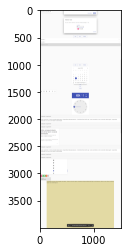

In [6]:
class JDIDatasetBuilder(DatasetBuilder):

    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_URL)
        #driver.set_window_size(width=1920, height=8400)
        driver.set_window_size(width=1500, height=4000)
        
#         driver.find_element_by_id("user-icon").click()
#         driver.find_element_by_id("name").send_keys(LOGIN)
#         driver.find_element_by_id("password").send_keys(PASSWORD)
#         driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
#         driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/a/div").click()
#         driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/ul/li[8]/a").click()
#         driver.find_element_by_xpath("/html/body/div/div/div/div[1]/div/div[2]/div/div").click()

#         driver.find_element_by_link_text("Service").click()
#         driver.find_element_by_link_text("Complex Table").click()
#         maximize_window(driver=driver)
        
with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    dataset_json = builder.dataset_json
    plt.imshow(plt.imread(f'MUI_model/dataset/images/{DATASET_NAME}.png'))
    

In [7]:
elements_df['label_text'] = elements_df.attributes.apply(lambda x: x.get('data-label') if x is not None else 'n/a').fillna('n/a')

In [8]:
elements_df['label_text'].unique()

array(['n/a', 'backdrop', 'progress', 'textarea-autosize', 'snackbar',
       'button', 'icon', 'drawer', 'list', 'divider', 'alert',
       'typography', 'link', 'slider', 'app-bar', 'badge', 'grid', 'chip',
       'dialog', 'select', 'switch', 'button-group', 'accordion', 'card',
       'paper', 'tabs', 'avatar', 'text-field', 'container', 'checkbox',
       'table', 'popover', 'popper'], dtype=object)

In [9]:
elements_df['attributes'].head(20)

0                                        {'lang': 'en'}
1                                                  None
2                                  {'charset': 'utf-8'}
3              {'href': './favicon.ico', 'rel': 'icon'}
4     {'content': 'width=device-width,initial-scale=...
5         {'content': '#000000', 'name': 'theme-color'}
6     {'content': 'Web site created using create-rea...
7     {'href': './logo192.png', 'rel': 'apple-touch-...
8        {'href': './manifest.json', 'rel': 'manifest'}
9                                                  None
10          {'data-jss': '', 'data-meta': 'MuiSvgIcon'}
11           {'data-jss': '', 'data-meta': 'MuiAvatar'}
12      {'data-jss': '', 'data-meta': 'MuiTouchRipple'}
13       {'data-jss': '', 'data-meta': 'MuiButtonBase'}
14             {'data-jss': '', 'data-meta': 'MuiChip'}
15       {'data-jss': '', 'data-meta': 'MuiIconButton'}
16    {'data-jss': '', 'data-meta': 'PrivateSwitchBa...
17         {'data-jss': '', 'data-meta': 'MuiChe

In [10]:
DEVICE='cpu'

In [11]:
model = torch.load('MUI_model/model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=1087, out_features=128, bias=False)
  (batchNorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=128, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=40, bias=True)
)

In [12]:
dataset_name = 'mui-site121'

In [13]:
dataset = JDNDataset(datasets_list=[dataset_name], rebalance_and_shuffle=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1329 [00:00<?, ?it/s]

  0%|          | 0/1329 [00:00<?, ?it/s]

2021-08-27 15:51:12,661 -INFO - dataset.py:101 - self.df.shape: (1329, 34)
2021-08-27 15:51:12,662 -INFO - dataset.py:103 - Check for duplicates...
2021-08-27 15:51:12,664 -INFO - dataset.py:107 - Check for duplicates is OK
2021-08-27 15:51:12,686 -INFO - features_builder.py:480 - used column: tag_name
2021-08-27 15:51:12,688 -INFO - features_builder.py:483 - loading MUI_model/model/ohe_tag_name.pkl
2021-08-27 15:51:12,691 -INFO - features_builder.py:480 - used column: tag_name_parent
2021-08-27 15:51:12,692 -INFO - features_builder.py:483 - loading MUI_model/model/ohe_tag_name.pkl
2021-08-27 15:51:12,695 -INFO - features_builder.py:480 - used column: tag_name_upsib
2021-08-27 15:51:12,696 -INFO - features_builder.py:483 - loading MUI_model/model/ohe_tag_name.pkl
2021-08-27 15:51:12,698 -INFO - features_builder.py:480 - used column: tag_name_dnsib
2021-08-27 15:51:12,698 -INFO - features_builder.py:483 - loading MUI_model/model/ohe_tag_name.pkl
2021-08-27 15:51:12,700 -INFO - dataset_c

  0%|          | 0/1329 [00:00<?, ?it/s]

2021-08-27 15:51:12,818 -INFO - features_builder.py:401 - used column: attributes_parent


  0%|          | 0/1329 [00:00<?, ?it/s]

2021-08-27 15:51:12,943 -INFO - features_builder.py:401 - used column: attributes_upsib


  0%|          | 0/1329 [00:00<?, ?it/s]

2021-08-27 15:51:13,054 -INFO - features_builder.py:401 - used column: attributes_dnsib


  0%|          | 0/1329 [00:00<?, ?it/s]

2021-08-27 15:51:13,175 -INFO - dataset_collector.py:57 - attributes_sm: (1329, 74)
2021-08-27 15:51:13,176 -INFO - features_builder.py:440 - used column: attributes
2021-08-27 15:51:13,177 -INFO - features_builder.py:443 - TfIdfVectorizer for class attribute exists. Loaging...
2021-08-27 15:51:13,188 -INFO - features_builder.py:440 - used column: attributes_parent
2021-08-27 15:51:13,189 -INFO - features_builder.py:443 - TfIdfVectorizer for class attribute exists. Loaging...
2021-08-27 15:51:13,201 -INFO - features_builder.py:440 - used column: attributes_upsib
2021-08-27 15:51:13,203 -INFO - features_builder.py:443 - TfIdfVectorizer for class attribute exists. Loaging...
2021-08-27 15:51:13,213 -INFO - features_builder.py:440 - used column: attributes_dnsib
2021-08-27 15:51:13,214 -INFO - features_builder.py:443 - TfIdfVectorizer for class attribute exists. Loaging...
2021-08-27 15:51:13,223 -INFO - dataset_collector.py:64 - class_sm: (1329, 148)
2021-08-27 15:51:13,225 -INFO - featu

In [14]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, pin_memory=True)

In [15]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df['is_hidden'] = dataset.df.is_hidden.values
results_df

  0%|          | 0/1329 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label,is_hidden
0,0,0,n/a,n/a,0
1,0,0,n/a,n/a,0
2,0,0,n/a,n/a,0
3,0,0,n/a,n/a,0
4,0,0,n/a,n/a,0
...,...,...,...,...,...
1324,14,14,switch,switch,0
1325,0,0,n/a,n/a,0
1326,0,0,n/a,n/a,0
1327,0,0,n/a,n/a,0


In [16]:
results_df[results_df['y_true_label'] != 'n/a']

,y_true,y_pred,y_true_label,y_pred_label,is_hidden
6,3,3,link,link,0
20,28,28,checkbox,checkbox,0
25,2,2,icon,icon,0
34,2,2,icon,icon,0
36,12,12,button,button,0
...,...,...,...,...,...
1304,9,9,progress,progress,0
1310,12,12,button,button,0
1315,28,28,checkbox,checkbox,0
1321,2,2,icon,icon,0


In [17]:
accuracy(results_df)

2021-08-27 15:51:13,849 -INFO - common.py:101 - Accuracy:  193/205 = 0.9414634146341463, for 1329 elements


0.9414634146341463

In [18]:
list(dataset.classes_dict.keys())

['n/a',
 'backdrop',
 'icon',
 'link',
 'avatar',
 'paper',
 'bottom-navigation',
 'menu',
 'stepper',
 'progress',
 'box',
 'dialog',
 'button',
 'card',
 'switch',
 'typography',
 'container',
 'table',
 'popper',
 'breadcrumbs',
 'list',
 'alert',
 'chip',
 'select',
 'textarea-autosize',
 'accordion',
 'text-field',
 'radio',
 'checkbox',
 'drawer',
 'grid',
 'popover',
 'snackbar',
 'radiogroup',
 'slider',
 'divider',
 'badge',
 'app-bar',
 'button-group',
 'tabs']

In [19]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)


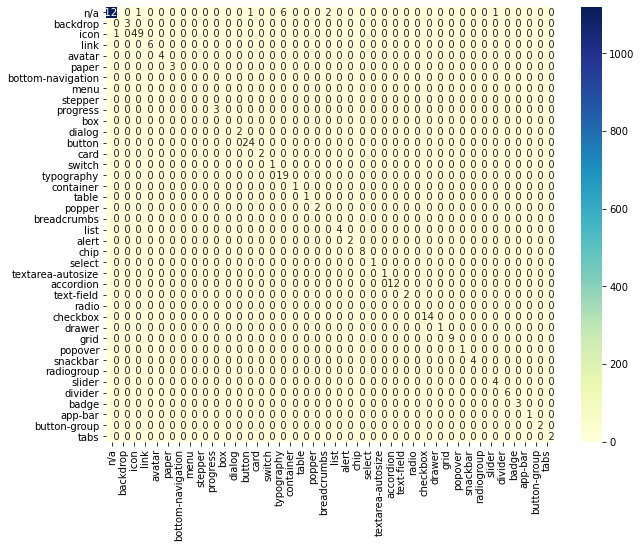

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [21]:
dataset.df['label_text_predicted'] = results_df.y_pred_label.values

(4000, 1500)


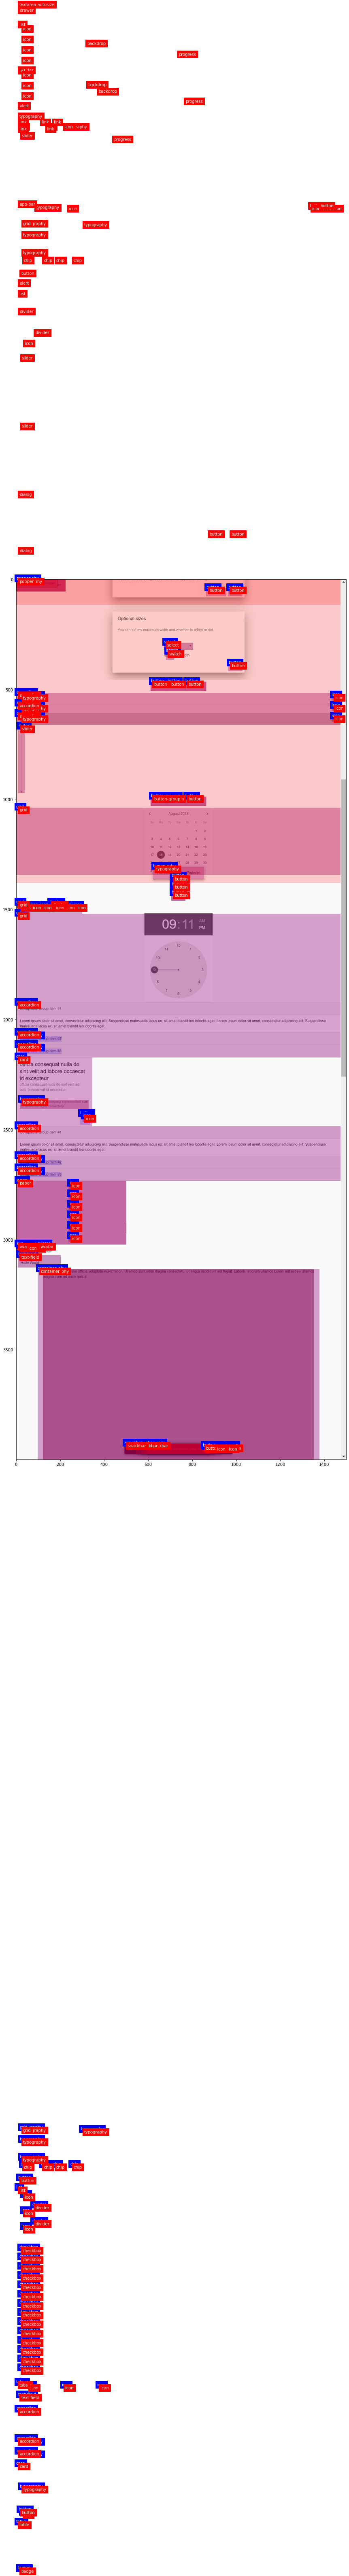

In [22]:
gray_img = get_grey_image(f'MUI_model/dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.df[dataset.df.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0) or (r.is_hidden == 1): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.df[dataset.df.label != dataset.classes_dict['n/a']].iterrows():
    if r.is_hidden == 1:
        continue
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    